In [1]:
import asyncio
import sys
from typing import Literal

import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from litellm import acompletion, completion_cost
from pydantic import BaseModel
from tqdm.asyncio import tqdm

sys.path.append("../..")

from climateguard.evaluation import evaluation_report

pio.renderers.default = "vscode+png"

## Load the labelled Mediatree transcripts


In [2]:
df_train = pd.read_csv("../../data/benchmark/mediatree_train.csv", index_col=0)
df_test = pd.read_csv("../../data/benchmark/mediatree_test.csv", index_col=0)

df_train

,text,cards_true
id,,
7dbf1dffa1716beb1ed686a1726426a016f75e834fd071764b1a2eb187893133,se permet de le signaler a écrit une excellent...,6_advocates_are_biased
fe45f27ffcbf85e6d48e6b60be4bcd530c65c67f6ab52b01fbe9179795e74677,plutôt que les êtres humains qui peut être pan...,2_humans_are_not_the_cause
da35cde6d2518f04767ec9f1757bbb58321fb6348744406fa6f6c8501f68cacb,est celle de tous les du changement climatique...,1_its_not_happening
92c19697034802208ef99474bde8a2daee3db8657bcfc38123a2f8956a15b8a1,je voulais savoir s'il y avait eu avoir confir...,1_its_not_happening
3d712b6a6f19bb5b2e64c0745e2c4533e0f5493358f1d37fbfedebd9580e9650,la réponse tient la ville réponse comme ils le...,4_solutions_are_ineffective_or_harmful
...,...,...
830985e89d6476432408368ba20cdec1d35a4ef2641b8b1e415d61c6cd3ddeb1,à cause des vaches tout ça pour ne pas remettr...,4_solutions_are_ineffective_or_harmful
8f0b256abb7edcc0d0deece2cc9e13aa339d27e95665624d2394d63986392a04,faut que le président de la république s'engag...,4_solutions_are_ineffective_or_harmful
dff5b2234dde58729e9489a7f5ef5dfdc1e752ce721ac658ab87b5249d13c1b8,bourgeois pousse moins leurs enfants euh les m...,5_science_is_uncertain


## Improve our prompts pipeline on the train set


In [3]:
# Limit concurrency
semaphore = asyncio.Semaphore(100)


async def predict_cards(
    text: str,
) -> Literal[
    "0_accepted",
    "1_its_not_happening",
    "2_humans_are_not_the_cause",
    "3_impacts_are_not_bad",
    "4_solutions_are_ineffective_or_harmful",
    "5_science_is_uncertain",
    "6_advocates_are_biased",
    "7_fossil_fuels_are_needed",
]:
    messages = [
        {
            "role": "system",
            "content": """Tu es un expert en désinformation sur les questions environnementales, spécialiste en science climatique et bien informé sur le GIEC. L'utilisateur va te fournir un extrait de deux minutes d'une retranscription d'un programme télévisé ou radiophonique. Ta mission est de classer cette retranscription dans la catégorie appropriée.

# Catégories prédéfinies

- 0_accepted: Le passage n'a pas de contenu climatosceptique évident et est accepté tel quel.
- 1_its_not_happening: Négation du réchauffement climatique ou allégations selon lesquelles les signes de changement climatique ne seraient pas avérés, tels que la fonte des glaces ou l'élévation du niveau de la mer.
- 2_humans_are_not_the_cause: Refus de reconnaître que les gaz à effet de serre produits par l'activité humaine sont la cause du changement climatique, attribuant plutôt cela à des variations naturelles ou autres phénomènes.
- 3_impacts_are_not_bad: Minimisation des impacts du changement climatique, suggérant qu'ils pourraient être bénins ou même bénéfiques.
- 4_solutions_are_ineffective_or_harmful: Critique des solutions climatiques, affirmant qu'elles sont nuisibles, inutiles, ou inefficaces.
- 5_science_is_uncertain: Contestation de la validité de la science climatique, affirmant qu'elle est incertaine, biaisée ou peu fiable.
- 6_advocates_are_biased: Accusations de partialité ou de motivations politiques parmi les scientifiques et les défenseurs de l'action climatique, allant jusqu'à suggérer un alarmisme ou une conspiration.
- 7_fossil_fuels_are_needed: Arguments en faveur de l'utilisation continue des combustibles fossiles pour le développement économique et le maintien du niveau de vie.

# Exemples

## Exemple 0

<extrait>
les scientifiques observent une hausse des températures mondiales, entraînant des changements climatiques visibles ils soulignent la nécessité d'agir pour en limiter les impacts
</extrait>
<catégorie>0_accepted</catégorie>

## Exemple 1

<extrait>
la fréquence des discussions sur la crise climatique semble augmenter mais certains experts proposent que les avertissements sur le climat pourraient être exagérés faisant souvent valoir que les fluctuations climatiques sont tout à fait naturelles et que les vérités scientifiques sont parfois altérées pour servir des intérêts politiques
</extrait>
</passage climatosceptique>
<catégorie>1_its_not_happening</catégorie>

## Exemple 2

<extrait>
il est contesté que la contribution humaine aux niveaux de CO2 soit réellement significative certains experts soutiennent que les océans jouent un rôle bien plus important dans l'émission de ce gaz
</extrait>
<catégorie>2_humans_are_not_the_cause</catégorie>

## Exemple 3

<extrait>
il est important de noter que beaucoup de régions touchées par des événements climatiques extrêmes retrouvent leur équilibre naturel et peuvent même bénéficier de ces changements car plusieurs études montrent que certaines espèces et écosystèmes s'adaptent efficacement aux variations climatiques
</extrait>
<catégorie>3_impacts_are_not_bad</catégorie>

## Exemple 4

<extrait>
de nombreux experts remettent en question l'efficacité des initiatives visant à réduire la pollution, arguant qu'elles ne font qu'ajouter des coûts économiques sans réel impact positif sur l'environnement
</extrait>
<catégorie>4_solutions_are_ineffective_or_harmful</catégorie>

## Exemple 5

<extrait>
En réfléchissant à la situation on peut voir un parallèle avec le débat climatique de nombreux sceptiques pensent que le discours autour du climat est devenu une sorte de dogme où la critique est difficilement tolérée
</extrait>
<catégorie>5_science_is_uncertain</catégorie>

## Exemple 6

<extrait>
Certains médias et politiciens utilisent la peur du changement climatique pour avancer des agendas politiques partisans, affirmant que les scientifiques amplifient les données pour obtenir plus de subventions.
</extrait>
<catégorie>6_advocates_are_biased</catégorie>

## Exemple 7

<extrait>
L'économie mondiale repose encore largement sur les combustibles fossiles, et leur abandon mettrait en péril notre développement économique et notre sécurité énergétique, car les énergies renouvelables ne sont pas encore prêtes à prendre le relais.
</extrait>
<catégorie>7_fossil_fuels_are_needed</catégorie>""",
        },
        {
            "role": "user",
            "content": f"<extrait>\n{text}\n</extrait>",
        },
    ]
    async with semaphore:
        response = await acompletion(
            "gpt-4o-mini",
            messages=messages,
            stop="</",
            temperature=0,
        )
    cards_class = response.choices[0].message.content.split("<catégorie>")[1]
    return cards_class

In [4]:
# Run the CARDS classification inference for all the claims
df_train["cards_pred"] = await tqdm.gather(
    *[predict_cards(text) for text in df_train["text"]]
)

100%|██████████| 145/145 [00:12<00:00, 11.56it/s] 


BINARY CLASSIFICATION REPORT

              precision    recall  f1-score   support

       False       0.67      0.60      0.64        48
        True       0.81      0.86      0.83        97

    accuracy                           0.77       145
   macro avg       0.74      0.73      0.74       145
weighted avg       0.77      0.77      0.77       145



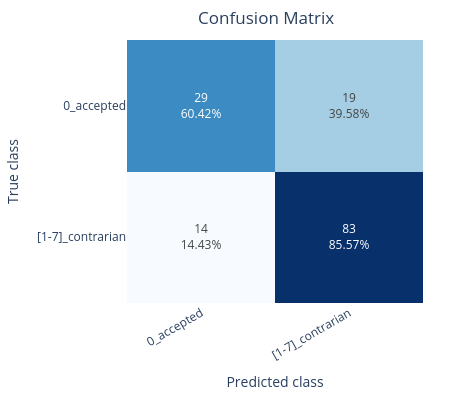

CARDS CLASSIFICATION REPORT

                                        precision    recall  f1-score   support

                            0_accepted       0.67      0.60      0.64        48
                   1_its_not_happening       0.25      0.10      0.14        10
            2_humans_are_not_the_cause       0.40      0.29      0.33         7
                 3_impacts_are_not_bad       0.40      0.33      0.36         6
4_solutions_are_ineffective_or_harmful       0.55      0.63      0.59        35
                5_science_is_uncertain       0.32      0.75      0.44         8
                6_advocates_are_biased       0.52      0.48      0.50        27
             7_fossil_fuels_are_needed       0.25      0.25      0.25         4

                              accuracy                           0.52       145
                             macro avg       0.42      0.43      0.41       145
                          weighted avg       0.53      0.52      0.52       145



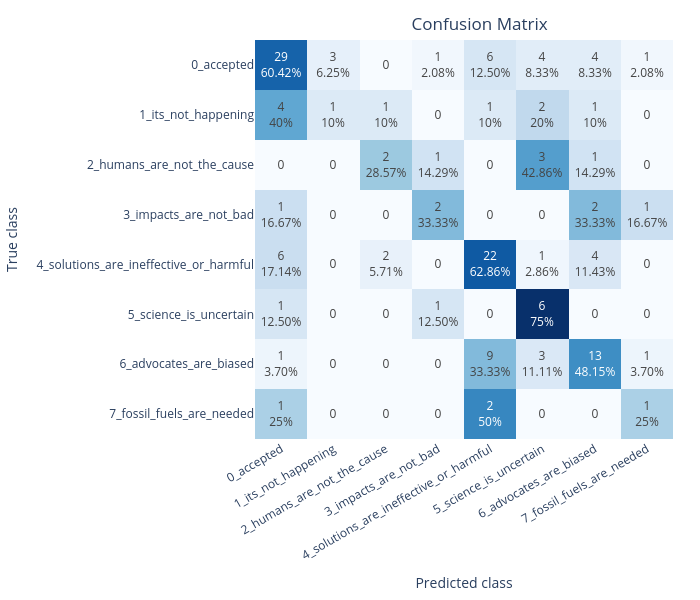

In [5]:
# Continue iterate on the prompts on the train set until we reach an acceptable performance
evaluation_report(df_train["cards_true"], df_train["cards_pred"])

## Evaluate our prompts performance on the test set


100%|██████████| 145/145 [00:04<00:00, 34.57it/s]

BINARY CLASSIFICATION REPORT

              precision    recall  f1-score   support

       False       0.52      0.46      0.49        48
        True       0.75      0.79      0.77        97

    accuracy                           0.68       145
   macro avg       0.64      0.63      0.63       145
weighted avg       0.67      0.68      0.68       145



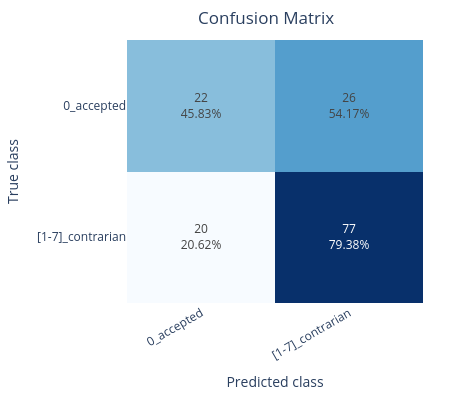

CARDS CLASSIFICATION REPORT

                                        precision    recall  f1-score   support

                            0_accepted       0.52      0.46      0.49        48
                   1_its_not_happening       0.75      0.27      0.40        11
            2_humans_are_not_the_cause       0.44      0.57      0.50         7
                 3_impacts_are_not_bad       0.00      0.00      0.00         6
4_solutions_are_ineffective_or_harmful       0.48      0.44      0.46        34
                5_science_is_uncertain       0.24      0.44      0.31         9
                6_advocates_are_biased       0.44      0.52      0.47        27
             7_fossil_fuels_are_needed       0.50      1.00      0.67         3

                              accuracy                           0.45       145
                             macro avg       0.42      0.46      0.41       145
                          weighted avg       0.47      0.45      0.45       145



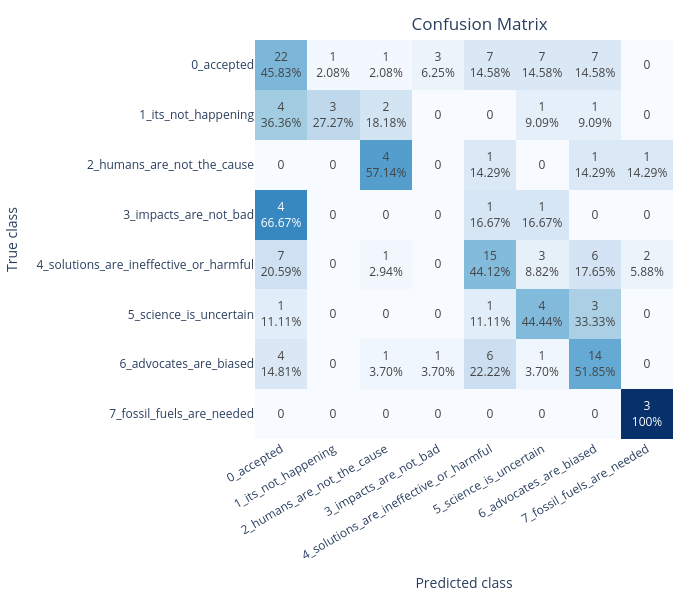

In [6]:
# Once we are happy with our prompts pipeline we can evaluate the performance on the test set
df_test["cards_pred"] = await tqdm.gather(
    *[predict_cards(text) for text in df_test["text"]]
)
evaluation_report(df_test["cards_true"], df_test["cards_pred"])